In [1]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

In [2]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


There are 20,640 instances in the dataset, which means that it is fairly small by machine learning standards.

Notice that the total_bedrooms attribute has only 20,433 non-null values, meaning that 207 districts are missing this feature.

All attributes are numerical, except for ocean_proximity. Its type is object, so it could hold any kind of Python object. But since you loaded this data from a CSV file, you know that it must be a text attribute.

In [4]:
housing["total_bedrooms"].value_counts()

total_bedrooms
280.0     55
331.0     51
345.0     50
343.0     49
393.0     49
          ..
1609.0     1
1591.0     1
2506.0     1
2238.0     1
1052.0     1
Name: count, Length: 1923, dtype: int64

In [5]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


how do you draw a histogram for each column to understand the distribution?

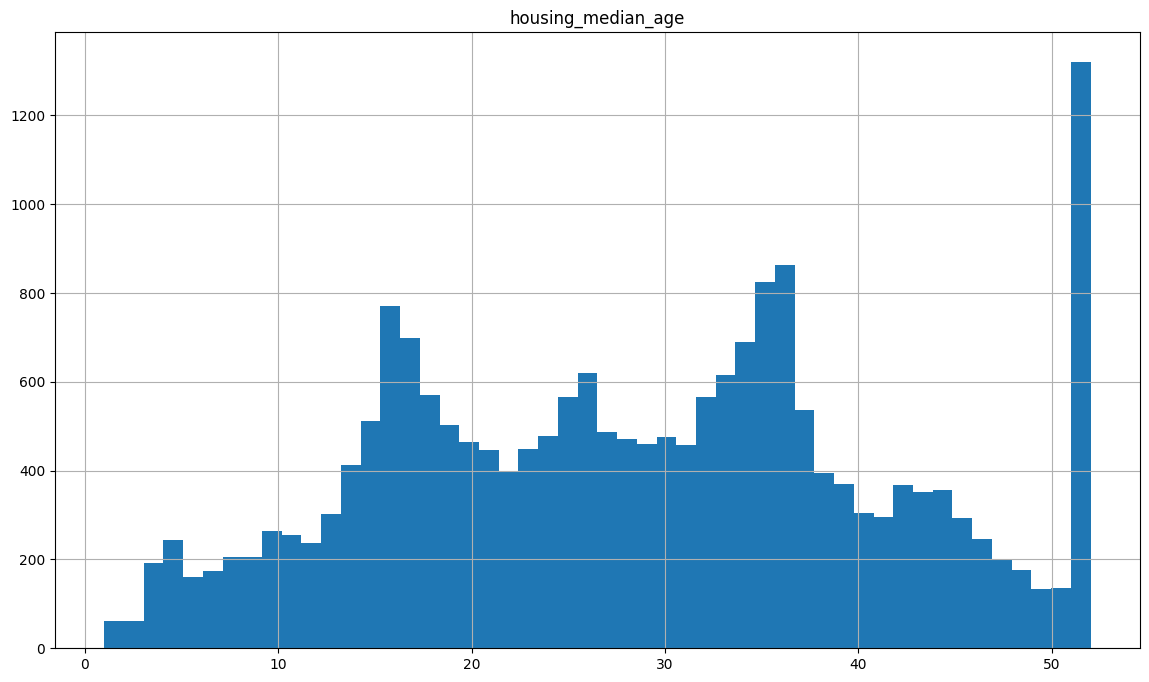

In [6]:
import matplotlib.pyplot as plt
housing[["housing_median_age"]].hist(bins=50, figsize=(14,8))
plt.show()

**Creating a test set:**
Creating a test set from the dataset is important as we need to evaluate how good our model is performing on data that it hasn't seen before.

**Data Snooping Bias:**
Now, here's where the problem begins. If you keep using the test set over and over to evaluate your robot, tweaking its learning every time it gets something wrong, you're essentially giving it hints about what's on the "final exam." This might make it seem like your robot is getting really good at identifying cats, but actually, it's just getting good at recognizing the cats in the test set.

Data snooping bias occurs when you make decisions about how to improve your model based on the test set. It's like a student who has somehow gotten all the answers to the final exam ahead of time. Sure, they'll score 100%, but it doesn't mean they actually understand the material well.

In [7]:
def create_test_set(dataset, test_ratio):
  #moving 20% of data from dataset to testset
  shuffled_indices = np.random.permutation(len(dataset))
  test_set_size = int(len(dataset)*test_ratio)
  test_indices = shuffled_indices[:test_set_size]
  training_indices = shuffled_indices[test_set_size: ]
  return dataset.iloc[test_indices], dataset.iloc[training_indices]

**stable test/train split:**


In [8]:
import numpy as np
from zlib import crc32

def is_id_in_test_set(identifier, test_ratio): #identifier or row_id
  return crc32(np.int64(identifier)) < test_ratio * 2**32

def split_data_with_id_hash(data, test_ratio, id_column):
  ids = data[id_column]
  test_set = ids.apply(lambda id_ : is_id_in_test_set(id_, test_ratio))
  return data.loc[test_set], data.loc[~test_set]


In [9]:
housing_with_id = housing.reset_index()  # adds an `index` column
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "index")

In [10]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "id")

Until now we've been sampling randomly. This may introduce **sampling bias**.
Sampling bias happens when the catergory distribution in the sample set is different from the original distribution.
eg: if in a dataset there are 59 females to 41 males. When we sample randomly we might get 20 females and 80 males. Now in the sample set weight is given more to males, which is not the case in the original distribution. **This is sampling bias**.

We avoid sampling bias by maintaining the same distribution of categories in the sample set as the original set.

.

In [11]:
housing["income_cat"] = pd.cut(housing["median_income"], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1,2,3,4,5])

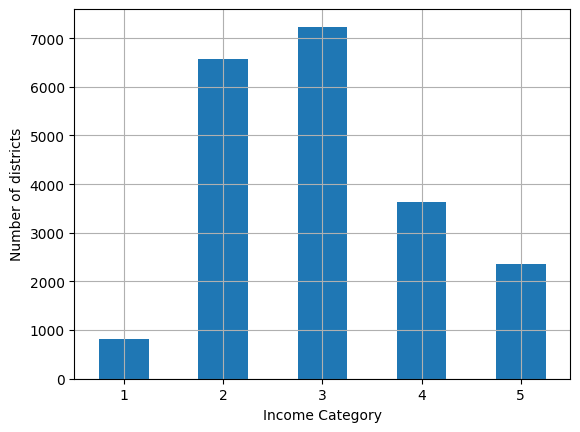

In [12]:
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income Category")
plt.ylabel("Number of districts")
plt.show()

In [13]:
(housing["income_cat"].value_counts()/len(housing["income_cat"])).sort_index()

income_cat
1    0.039826
2    0.318847
3    0.350581
4    0.176308
5    0.114438
Name: count, dtype: float64

In [14]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42) # train indices and test indices

strat_splits = []
for train_index, test_index in splitter.split(housing, housing["income_cat"]):
  strat_train_set_n = housing.iloc[train_index]
  strat_test_set_n = housing.iloc[test_index]
  strat_splits.append([strat_train_set_n, strat_test_set_n])

In [15]:
strat_train_set, strat_test_set = strat_splits[0]

In [16]:
(strat_test_set["income_cat"].value_counts()/len(strat_test_set["income_cat"])).sort_index()

income_cat
1    0.039971
2    0.318798
3    0.350533
4    0.176357
5    0.114341
Name: count, dtype: float64

Nice, we have the same distribution of categorical feature "income_cat" as the original data.

In [17]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

<ipython-input-17-ba84e3d1e141>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_.drop("income_cat", axis=1, inplace=True)
<ipython-input-17-ba84e3d1e141>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_.drop("income_cat", axis=1, inplace=True)


In [18]:
housing = strat_train_set.copy()

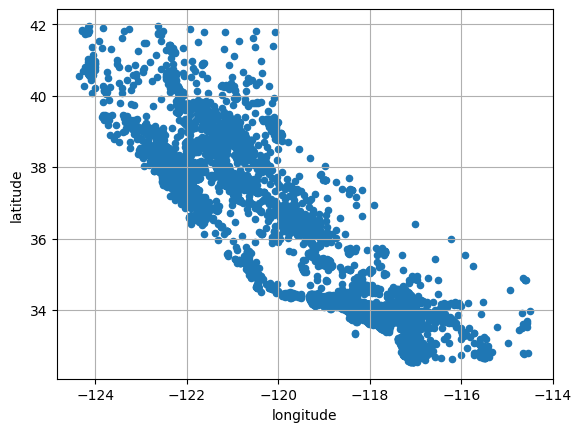

In [19]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True)
plt.show()

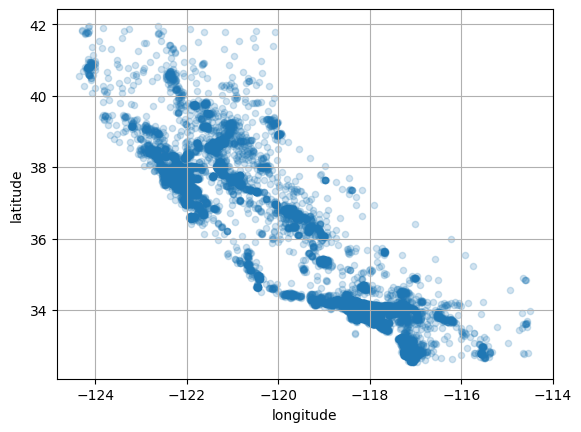

In [20]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, alpha=0.2)
plt.show()

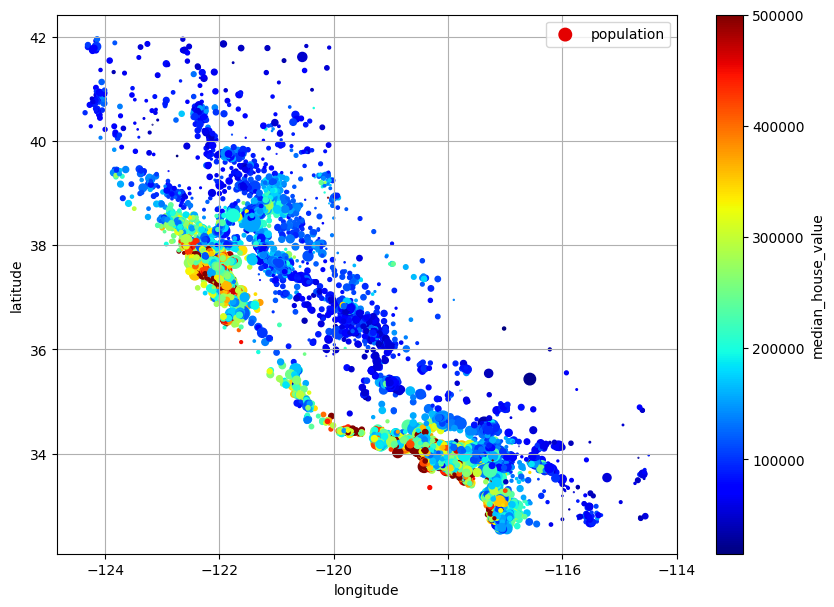

In [21]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True,
             s=housing["population"] / 100, label="population",
             c="median_house_value", cmap="jet", colorbar=True,
             legend=True, sharex=False, figsize=(10, 7))
plt.show()

In [22]:
housing.corr(numeric_only=True)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924213,-0.102937,0.044558,0.068210,0.104236,0.054261,-0.016542,-0.050859
latitude,-0.924213,1.000000,0.005692,-0.036753,-0.066391,-0.115677,-0.071604,-0.078137,-0.139584
housing_median_age,-0.102937,0.005692,1.000000,-0.361710,-0.317978,-0.301906,-0.300075,-0.127043,0.102175
total_rooms,0.044558,-0.036753,-0.361710,1.000000,0.930076,0.863967,0.916143,0.197720,0.137455
total_bedrooms,0.068210,-0.066391,-0.317978,0.930076,1.000000,0.886200,0.978822,-0.006038,0.054635
population,0.104236,-0.115677,-0.301906,0.863967,0.886200,1.000000,0.916237,0.004282,-0.020153
households,0.054261,-0.071604,-0.300075,0.916143,0.978822,0.916237,1.000000,0.013637,0.071426
median_income,-0.016542,-0.078137,-0.127043,0.197720,-0.006038,0.004282,0.013637,1.000000,0.688380
median_house_value,-0.050859,-0.139584,0.102175,0.137455,0.054635,-0.020153,0.071426,0.688380,1.000000


In [23]:
corr_matrix = housing.corr(numeric_only=True)

In [24]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

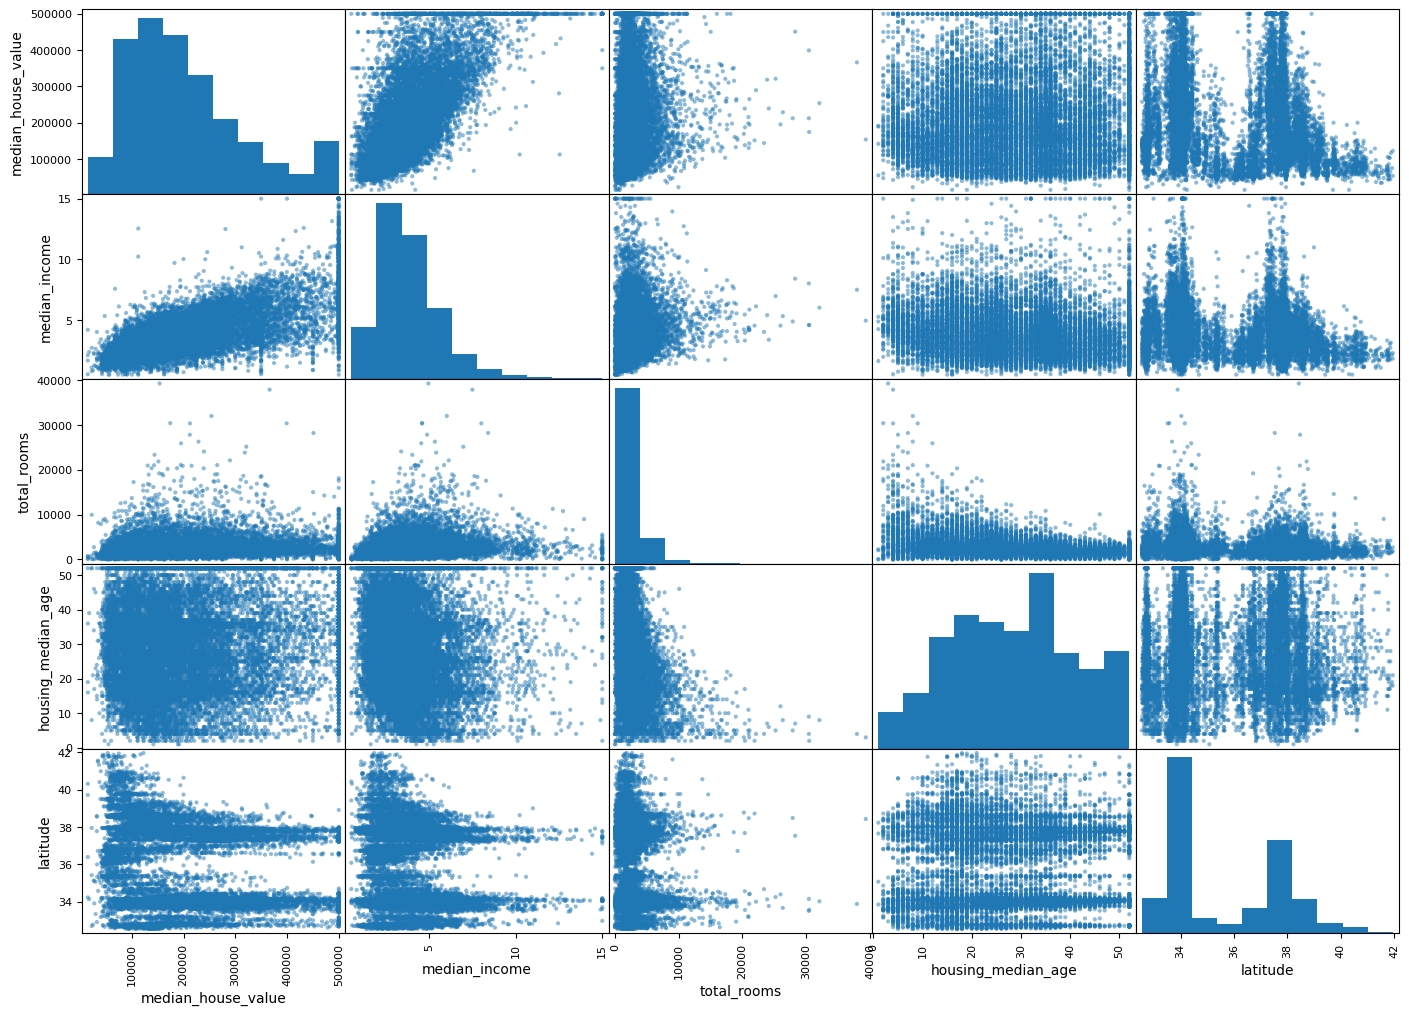

In [25]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age", "latitude"]

scatter_matrix(housing[attributes], figsize=(17,12))
plt.show()

<Axes: xlabel='median_income', ylabel='median_house_value'>

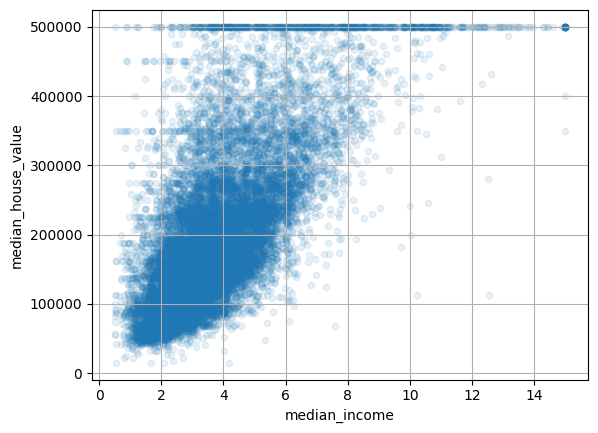

In [26]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1, grid=True)

In [27]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987,458300.0,NEAR BAY
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876,483800.0,<1H OCEAN
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330,101700.0,INLAND
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618,96100.0,INLAND
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292,361800.0,NEAR OCEAN


We can also experiment with various attribute combinations

In [28]:
housing["rooms_per_house"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_ratio"] = housing["total_rooms"]/housing["total_bedrooms"]
housing["people_per_house"] = housing["population"]/housing["households"]

In [29]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_house,bedrooms_ratio,people_per_house
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987,458300.0,NEAR BAY,3.211799,2.978475,1.524178
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876,483800.0,<1H OCEAN,5.504202,5.550847,1.865546
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330,101700.0,INLAND,5.334975,4.990783,2.768473
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618,96100.0,INLAND,5.351282,4.904818,2.365385
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292,361800.0,NEAR OCEAN,3.725256,3.605285,1.631399


In [30]:
corr = housing.corr(numeric_only=True)

In [31]:
corr

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_house,bedrooms_ratio,people_per_house
longitude,1.000000,-0.924213,-0.102937,0.044558,0.068210,0.104236,0.054261,-0.016542,-0.050859,-0.027899,-0.076512,0.024587
latitude,-0.924213,1.000000,0.005692,-0.036753,-0.066391,-0.115677,-0.071604,-0.078137,-0.139584,0.108037,0.081637,-0.026457
housing_median_age,-0.102937,0.005692,1.000000,-0.361710,-0.317978,-0.301906,-0.300075,-0.127043,0.102175,-0.153900,-0.164260,0.012771
total_rooms,0.044558,-0.036753,-0.361710,1.000000,0.930076,0.863967,0.916143,0.197720,0.137455,0.128631,0.191957,-0.037702
total_bedrooms,0.068210,-0.066391,-0.317978,0.930076,1.000000,0.886200,0.978822,-0.006038,0.054635,0.001569,-0.095259,-0.045017
population,0.104236,-0.115677,-0.301906,0.863967,0.886200,1.000000,0.916237,0.004282,-0.020153,-0.076603,-0.038998,0.085204
households,0.054261,-0.071604,-0.300075,0.916143,0.978822,0.916237,1.000000,0.013637,0.071426,-0.082242,-0.073657,-0.042452
median_income,-0.016542,-0.078137,-0.127043,0.197720,-0.006038,0.004282,0.013637,1.000000,0.688380,0.314316,0.766595,-0.006662
median_house_value,-0.050859,-0.139584,0.102175,0.137455,0.054635,-0.020153,0.071426,0.688380,1.000000,0.143663,0.380920,-0.038224
rooms_per_house,-0.027899,0.108037,-0.153900,0.128631,0.001569,-0.076603,-0.082242,0.314316,0.143663,1.000000,0.427749,0.003868


In [32]:
corr["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
bedrooms_ratio        0.380920
rooms_per_house       0.143663
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
people_per_house     -0.038224
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

Preparing the data for ML algorithms

1.   clean the training set eg: Imputing
2. Handling text and categorical attributes




In [33]:
housing = strat_train_set.copy()

In [34]:
housing = housing.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [35]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16512 entries, 13096 to 19888
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16344 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   ocean_proximity     16512 non-null  object 
dtypes: float64(8), object(1)
memory usage: 1.3+ MB


We have some missing values in total bedrooms

In [36]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')

Missing values can also be replaced with the mean value (strategy="mean"), or with the most frequent value (strategy="most_frequent"), or with a constant value (strategy="constant", fill_value=…​). The last two strategies support non-numerical data.


In [37]:
housing_num = housing.select_dtypes(include=[np.number])
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [38]:
X = imputer.transform(housing_num)

In [39]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)

# Handling text and categorical attributes

In [40]:
housing_cat = housing[['ocean_proximity']]

In [41]:
housing_cat

,ocean_proximity
13096,NEAR BAY
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN
...,...
14207,<1H OCEAN
13105,INLAND
19301,NEAR OCEAN
19121,<1H OCEAN


In [42]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()

housing_cat_onehot = cat_encoder.fit_transform(housing_cat)

In [43]:
housing_cat_onehot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [44]:
 cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

Pandas has a function called get_dummies(), which also converts each categorical feature into a one-hot representation, with one binary feature per category

```
>>> df_test = pd.DataFrame({"ocean_proximity": ["INLAND", "NEAR BAY"]})

>>> pd.get_dummies(df_test)
```
```
  ocean_proximity_INLAND  ocean_proximity_NEAR BAY
0                       1                         0
1                       0                         1
```

It looks nice and simple, so why not use it instead of OneHotEncoder? Well, the advantage of OneHotEncoder is that it remembers which categories it was trained on. This is very important because once your model is in production, it should be fed exactly the same features as during training: no more, no less

But OneHotEncoder is smarter: it will detect the unknown category and raise an exception. If you prefer, you can set the handle_unknown hyperparameter to "ignore", in which case it will just represent the unknown category with zeros:


```
>>> cat_encoder.handle_unknown = "ignore"
>>> cat_encoder.transform(df_test_unknown)
array([[0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]])
```




In [45]:
cat_encoder.handle_unknown = "ignore"

When we fit any scikit-learn estimator using a dataframe, the estimator stores the feature names in the *feature_names_in_* attribute. Scikit-learn then ensures that any dataframe fed to this estimator has the same features. Transformers also provide *get_feature_names_out()* method to build a dataframe around transformers output.


In [46]:
cat_encoder.feature_names_in_

array(['ocean_proximity'], dtype=object)

# Feature Scaling and Transformation

Feature Scaling

ML Algorithms don't perform well when features(numerical) have different scales. Without any scaling models will show bias towards features having a big range.

Feature scaling is done using 2 ways:

1. Min-Max Scaling (Normalization)
2. Z-score standardization

Min-Max Scaling:


*   bounds the feature range b/w 0 and 1
*  $\text{Normalized Score} = \frac{{X_i}-\text{Min(X)}}{{Max({X})} - {Min({X})}}$

Example:

For a score that ranges from 0 to 10:
If a person scored a 7, then the normalized score would be:

$\frac{7 - 0}{10 - 0} = 0.7$

For a score that ranges from 0 to 100:
If a person scored 70, then the normalized score would be:

$\frac{70 - 0}{100 - 0} = 0.7$









In [47]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler(feature_range=(-1,1))
housing_min_max_scaled = min_max_scaler.fit_transform(housing_num)

Z-score standardization:
This method also helps in comparing scores from different scales by converting them into a standard format with a mean (average) of 0 and a standard deviation of 1. The formula for Z-Score Standardization is:

$\text{Z-Score} = \frac{\text{Score} - \text{Mean}}{\text{Standard Deviation}}$

To apply this, you would need to know the average and standard deviation of the scores in each range:

Example:

Assume the average for the 0-10 range is 5 and the standard deviation is 2.5:
If a person scored a 7, then the Z-Score would be:

$\frac{7 - 5}{2.5} = 0.8$

Assume the average for the 0-100 range is 50 and the standard deviation is 25:
If a person scored 70, then the Z-Score would be:

$\frac{70 - 50}{25} = 0.8$

Again, this standardizes scores on different scales, making them directly comparable



In [48]:
from sklearn.preprocessing import StandardScaler

standard_scaler = StandardScaler()

standardScalinghousing = standard_scaler.fit_transform(housing_num)

In [49]:
from sklearn.metrics.pairwise import rbf_kernel

age_simil_35 = rbf_kernel(housing[["housing_median_age"]], [[35]], gamma=0.1)

In [50]:
age_simil_35

array([[2.81118530e-13],
       [8.20849986e-02],
       [6.70320046e-01],
       ...,
       [9.55316054e-22],
       [6.70320046e-01],
       [3.03539138e-04]])

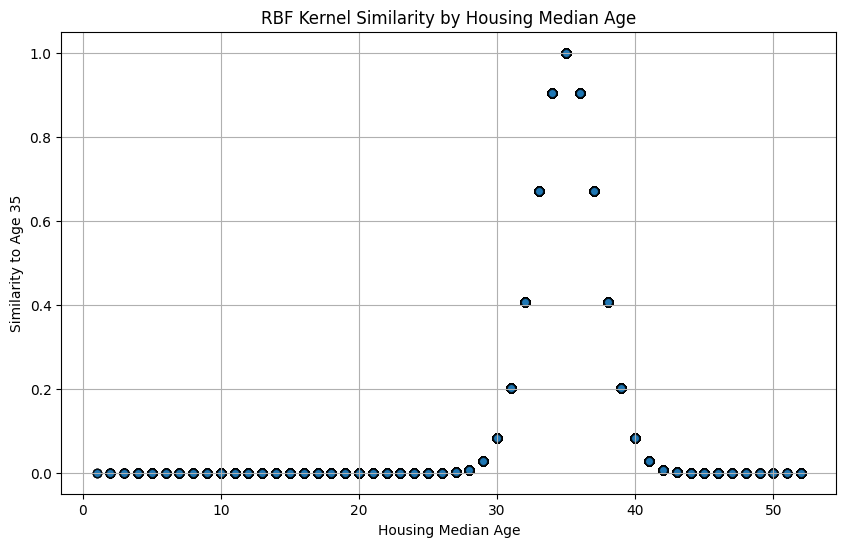

In [51]:
plt.figure(figsize=(10, 6))  # Set the figure size for better readability
plt.scatter(housing['housing_median_age'], age_simil_35, edgecolor='k', alpha=0.7)
plt.title('RBF Kernel Similarity by Housing Median Age')
plt.xlabel('Housing Median Age')
plt.ylabel('Similarity to Age 35')
plt.grid(True)
plt.show()


Up until now we've seen distributions of the features. It's time we see the distribution of labels as well

array([[<Axes: title={'center': 'median_house_value'}>]], dtype=object)

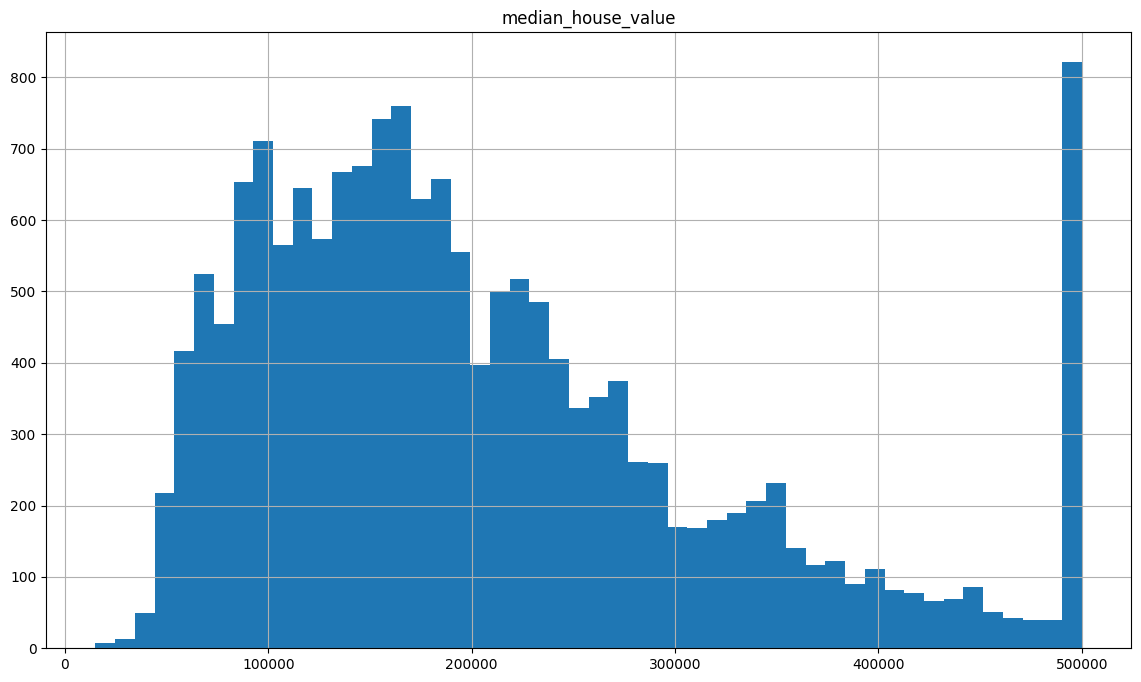

In [52]:
housing_labels.to_frame().hist(bins=50, figsize=(14,8))

As you can see the labels have a heavy tail. You can use a logarithmetic transformer to reduce the heavy tail. But, if we transform the labels, our model will be trained on transformed labels, in this case logarithmetic labels. So, in order to get the correct predictions we inverse transform using an inverse transformer, in this case an exponential transformer.

Suppose, lets say we use min max scaling to transform the labels and train the model. The predictions that the model would give us are the scaled predictions. Our correct predictions would be the predictions which are rescaled back.

In [53]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

target_scaler = StandardScaler()
scaled_labels = target_scaler.fit_transform(housing_labels.to_frame())

model = LinearRegression()
model.fit(housing[['median_income']], scaled_labels)

new_test_data = housing[['median_income']].iloc[:5]

scaled_predictions = model.predict(new_test_data)
predictions = target_scaler.inverse_transform(scaled_predictions)

In [54]:
pd.DataFrame(predictions)

,0
0,131997.152759
1,299359.358444
2,146023.371857
3,138840.336531
4,192016.615576


This works fine, but a simpler way to do this is to use TransformedTargetRegressor.

In [55]:
from sklearn.compose import TransformedTargetRegressor

model = TransformedTargetRegressor(LinearRegression(), transformer = StandardScaler())
model.fit(housing[["median_income"]], housing_labels)
model.predict(housing[["median_income"]].iloc[:5])

array([131997.15275877, 299359.35844434, 146023.37185694, 138840.33653057,
       192016.61557639])

# Custom Transformers

<Axes: >

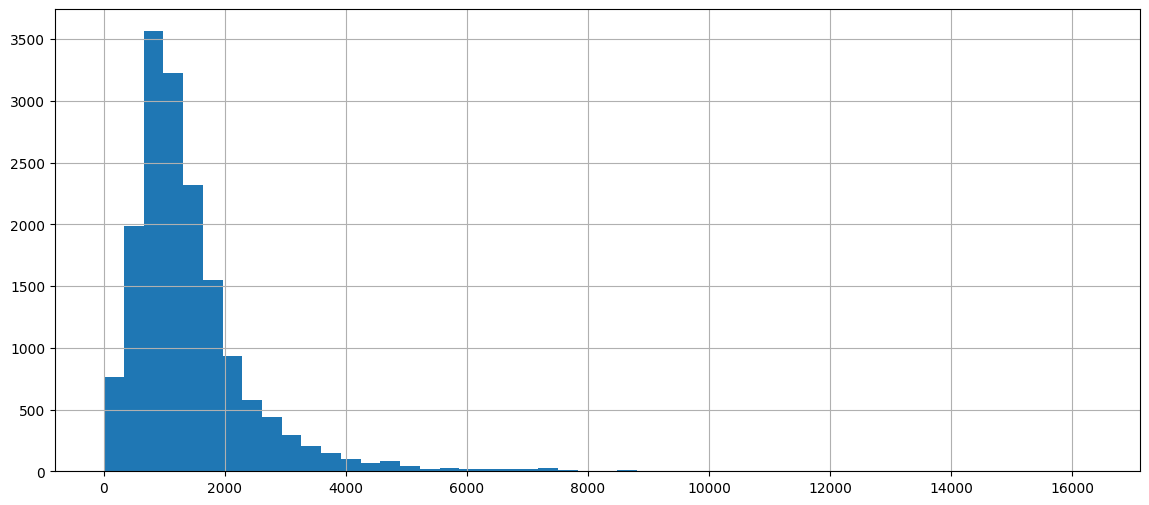

In [56]:
housing["population"].hist(bins=50, figsize = (14,6))

Sometimes we want some specific transformation that an inbuilt transformer may not provide. In such cases as the name implies we use custom transformers.

Generally, transformers train from some data(.fit() method), estimate some things and apply transformation on some data.

When there is no need for training, you can just write a function that takes a NumPy array as input and outputs the transformed array.

For eg: When there are long heavy tailed distributions we can replace them with their logarithms.



In [57]:
from sklearn.preprocessing import FunctionTransformer

log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
log_pop = log_transformer.transform(housing['population'])
log_pop.to_frame()
log_pop

13096    7.362645
14973    6.501290
3785     6.331502
14689    7.520235
20507    7.555905
           ...   
14207    6.843750
13105    7.257708
19301    7.942362
19121    7.452982
19888    6.525030
Name: population, Length: 16512, dtype: float64

another example: RBF transformer


In [58]:
from sklearn.metrics.pairwise import rbf_kernel

rbf_transformer = FunctionTransformer(rbf_kernel, kw_args=dict(Y=[[35.]], gamma=0.1))
age_simil_35 = rbf_transformer.transform(housing[["housing_median_age"]])
pd.DataFrame(age_simil_35)

,0
0,2.811185e-13
1,8.208500e-02
2,6.703200e-01
3,8.489044e-15
4,9.048374e-01
...,...
16507,2.732372e-02
16508,5.573904e-07
16509,9.553161e-22
16510,6.703200e-01


In [59]:
sf_coords = 37.7749, -122.41
sf_transformer = FunctionTransformer(rbf_kernel,
                                     kw_args=dict(Y=[sf_coords], gamma=0.1))
sf_simil = sf_transformer.transform(housing[["latitude", "longitude"]])

In [60]:
sf_simil

array([[0.999927  ],
       [0.05258419],
       [0.94864161],
       ...,
       [0.00388525],
       [0.05038518],
       [0.99868067]])

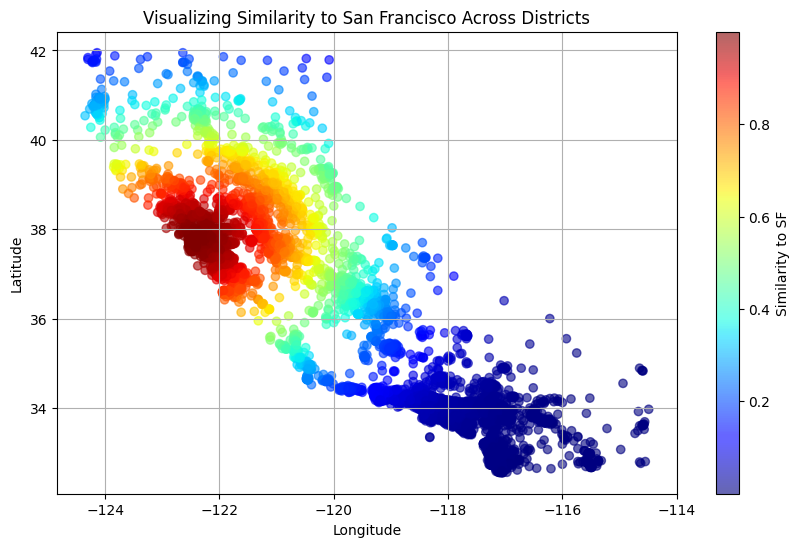

In [61]:
plt.figure(figsize=(10,6))
plt.scatter(housing['longitude'], housing['latitude'], c=sf_simil, cmap='jet', alpha=0.6)
plt.colorbar(label='Similarity to SF')
plt.title('Visualizing Similarity to San Francisco Across Districts')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

Up until now, we've seen Function Transformer which is used when there's no need to train.

When there's a need to train we need to use a custom class. This custom class will have three methods
1. fit() - must return self
2. transform()
3. fit_transform()

You can get fit_transform() for free by simply adding TransformerMixin as a base class: the default implementation will just call fit() and then transform()

If you add BaseEstimator as a base class (and avoid using *args and **kwargs in your constructor), you will also get two extra methods: get_params() and set_params(). These will be useful for automatic hyperparameter tuning.

We are now going to create a standard scaler using custom transformers.

Standard scaler Algorithm:
1. Takes in a list of numbers as input
2. computes the mean and standard deviation of the list
3. for each element in the list, compute $\frac{x_i-{\text Mean}}{\text{Standard deviation}}$

In [62]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted

class StandardScalerClone(BaseEstimator, TransformerMixin):
  def __init__(self, strategy='mean'):
    self.strategy = strategy

  def fit(self, X, y=None): #X is a numpy array.
    self.mean_ = X.mean(axis=0)
    self.sd_ = X.std(axis=0)
    self.n_features_in_ = X.shape[1]
    return self

  def transform(self, X):
    check_is_fitted(self)
    X = check_array(X)
    assert self.n_features_in_ == X.shape[1]
    if self.strategy == 'mean':
      X = X - self.mean_
    return X/self.sd_

In [63]:
x = np.array([[1,2,3,4], [5,6,7,8]])
std_scaler = StandardScalerClone()
std_scaler.fit_transform(x)


array([[-1., -1., -1., -1.],
       [ 1.,  1.,  1.,  1.]])

We can verify if the standard scaler works correctly by comparing the output with the inbuilt standard scaler.

In [64]:
std_sc = StandardScaler()
std_sc.fit_transform(x)

array([[-1., -1., -1., -1.],
       [ 1.,  1.,  1.,  1.]])

In [65]:
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import rbf_kernel

clusters = KMeans(n_clusters=10, random_state=42)
x = clusters.fit(housing[["latitude", "longitude"]], sample_weight=housing_labels)

rbf_simil_centers_districts = rbf_kernel(housing[["latitude", "longitude"]], clusters.cluster_centers_, gamma=1)
pd.DataFrame(rbf_simil_centers_districts)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,0,1,2,3,4,5,6,7,8,9
0,6.266754e-17,1.409316e-01,4.170577e-14,7.702910e-05,1.884414e-03,7.901656e-02,1.335612e-23,9.866155e-01,5.424322e-08,6.039721e-01
1,6.272872e-01,1.499801e-09,9.895460e-01,4.568884e-04,2.600164e-26,5.824885e-14,3.831246e-02,1.305593e-13,1.108916e-01,1.622968e-10
2,2.719312e-17,2.887313e-01,1.390517e-14,1.569452e-04,9.691086e-03,4.448997e-01,3.964361e-24,7.001000e-01,1.057212e-08,2.984321e-01
3,6.469022e-01,1.817572e-14,2.087418e-01,5.432999e-07,2.642785e-34,1.773954e-19,5.126671e-01,5.197129e-20,3.747125e-04,2.751253e-16
4,8.554375e-01,2.466254e-11,8.949351e-01,3.425720e-05,2.771319e-29,3.927149e-16,1.434726e-01,1.096747e-15,3.225800e-02,2.571331e-12
...,...,...,...,...,...,...,...,...,...,...
16507,6.660652e-01,1.991377e-10,9.575365e-01,1.087950e-04,9.622372e-28,4.281289e-15,6.584172e-02,1.738875e-14,7.921753e-02,3.015148e-11
16508,2.025092e-04,6.123196e-03,2.228289e-03,8.415148e-01,1.874170e-13,3.787568e-05,5.980232e-08,9.096807e-06,5.914352e-02,3.715916e-04
16509,1.253731e-01,2.692952e-19,2.371862e-02,1.331843e-10,1.143859e-41,2.142292e-25,8.864386e-01,5.495454e-25,8.282638e-06,1.277550e-20
16510,6.369034e-01,9.227453e-10,9.942321e-01,3.186423e-04,1.177279e-26,3.045224e-14,4.371664e-02,8.348118e-14,1.064230e-01,1.128956e-10


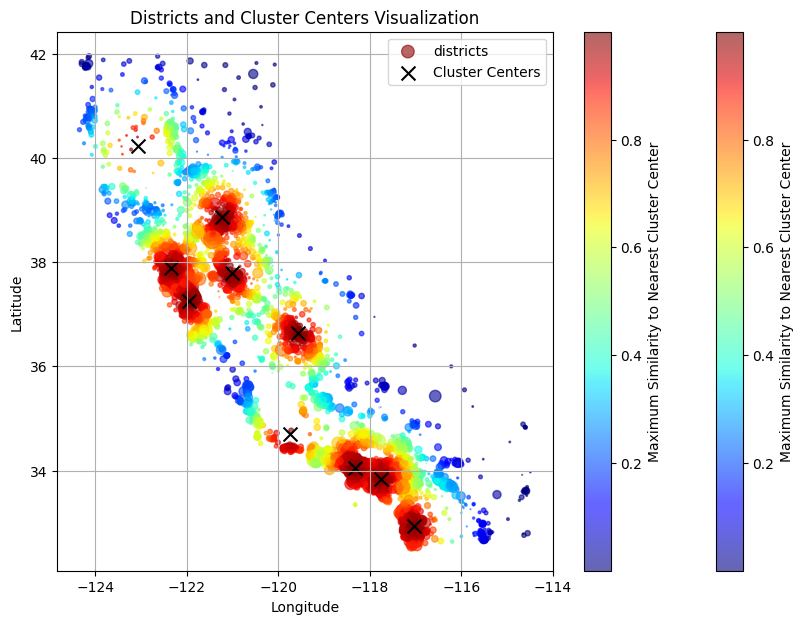

In [66]:
plt.figure(figsize=(10,7))
d_scatter = plt.scatter(housing["longitude"], housing["latitude"], c=rbf_simil_centers_districts.max(axis=1), cmap='jet', alpha=0.6,s=housing["population"] / 100,label="districts")
plt.scatter(x.cluster_centers_[:, 1], x.cluster_centers_[:,0], marker="x", s=100, c="black",  label='Cluster Centers')
# x.cluster_centers_
plt.colorbar(d_scatter, label='Maximum Similarity to Nearest Cluster Center')
plt.title('Districts and Cluster Centers Visualization')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True)
plt.colorbar(d_scatter, label="Maximum Similarity to Nearest Cluster Center")

Lets implement a custom transformer for the above

In [67]:
from sklearn.cluster import KMeans

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self  # always return self!

    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)

    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

In [68]:
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
similarities = cluster_simil.fit_transform(housing[["latitude", "longitude"]],
                                           sample_weight=housing_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


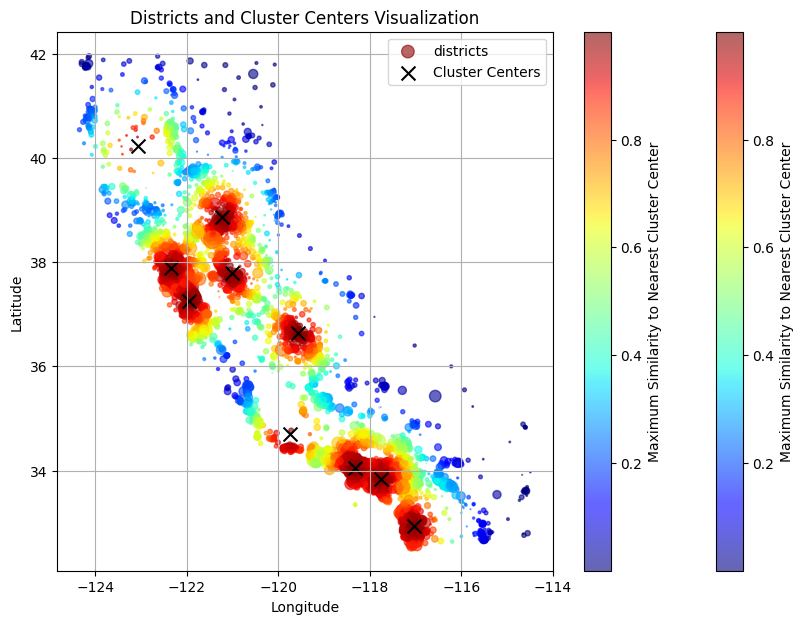

In [69]:
plt.figure(figsize=(10,7))
d_scatter = plt.scatter(housing["longitude"], housing["latitude"], c=similarities.max(axis=1), cmap='jet', alpha=0.6,s=housing["population"] / 100,label="districts")
plt.scatter(cluster_simil.kmeans_.cluster_centers_[:, 1], cluster_simil.kmeans_.cluster_centers_[:,0], marker="x", s=100, c="black",  label='Cluster Centers')
# x.cluster_centers_
plt.colorbar(d_scatter, label='Maximum Similarity to Nearest Cluster Center')
plt.title('Districts and Cluster Centers Visualization')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True)
plt.colorbar(d_scatter, label="Maximum Similarity to Nearest Cluster Center")

# Transformation Pipelines

Pipeline: Sequence of data processing steps

We can build a pipeline using scikit learn in the following way:

In [70]:
import sklearn
from sklearn.pipeline import Pipeline
sklearn.set_config(display="diagram")

The Pipeline object constructor takes a list of tuples. A tuple here is a **name-estimator** pair.

Rules to follow when creating a pipeline:

1. Names should be unique and should not start with double underscores. Names are useful in hyperparameter tuning.
2. Estimators inside the pipeline should be transformers i.e., it should contain **.fit_transform()**.
3. The final estimator in the pipeline can be anything(predictor, estimator, transformer etc.,)







In [71]:
pipeline = Pipeline([
                    ("impute", SimpleImputer(strategy="mean")),
                    ("standardize",StandardScaler())
                    ])

If you don't want to name the transformers, you can use the **make_pipeline() function** instead.

 it takes transformers as positional arguments and creates a Pipeline using the names of the transformers’ classes, in lowercase and without underscores

In [72]:
from sklearn.pipeline import make_pipeline
num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

When you call the pipeline’s fit() method, it calls fit_transform() sequentially on all the transformers, passing the output of each call as the parameter to the next call until it reaches the final estimator, for which it just calls the fit() method.

In [73]:
housing_num_prepared = num_pipeline.fit_transform(housing_num)
housing_num_prepared[:2].round(2)

array([[-1.42,  1.01,  1.86,  0.31,  1.37,  0.14,  1.39, -0.94],
       [ 0.6 , -0.7 ,  0.91, -0.31, -0.44, -0.69, -0.37,  1.17]])

In [74]:
df_housing_num_prepared = pd.DataFrame(
    housing_num_prepared, columns=num_pipeline.get_feature_names_out(),
    index=housing_num.index)

In [75]:
df_housing_num_prepared

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
13096,-1.423037,1.013606,1.861119,0.311912,1.368167,0.137460,1.394812,-0.936491
14973,0.596394,-0.702103,0.907630,-0.308620,-0.435925,-0.693771,-0.373485,1.171942
3785,-1.203098,1.276119,0.351428,-0.712240,-0.760709,-0.788768,-0.775727,-0.759789
14689,1.231216,-0.884924,-0.919891,0.702262,0.742306,0.383175,0.731375,-0.850281
20507,0.711362,-0.875549,0.589800,0.790125,1.595753,0.444376,1.755263,-0.180365
...,...,...,...,...,...,...,...,...
14207,0.586397,-0.833359,0.987087,-0.184147,0.140152,-0.445315,0.060101,0.444041
13105,0.131525,0.319822,-0.443146,0.139847,0.128298,-0.005950,0.083608,-0.685630
19301,1.256209,-1.428701,-1.237721,0.586026,0.562134,1.268299,0.679135,0.101049
19121,0.586397,-0.739605,0.669257,0.522417,0.794461,0.273563,0.882868,0.145396


In [76]:
num_pipeline[:]

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

In [77]:
from sklearn.compose import ColumnTransformer

num_attributes = list(housing_num.columns)
cat_attributes = list(housing_cat)

cat_pipeline = make_pipeline(SimpleImputer(strategy="most_frequent"), OneHotEncoder(handle_unknown="ignore"))

preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attributes),
    ("cat", cat_pipeline, cat_attributes)
])



```
  num_attributes = list(housing_num.columns)
  cat_attributes = list(housing_cat)
```
We've got the column names in this way. But at times we need to specify whole column names as below, which can be tedious

```
num_attribs = ["longitude", "latitude", "housing_median_age", "total_rooms",
               "total_bedrooms", "population", "households", "median_income"]
cat_attribs = ["ocean_proximity"]
```

A better way to do this is by using

**make_column_selector()**:

returns a selector function which selects all the features of a given type, such as numerical or categorical.

Also,
if you don't care about naming the transformers in the column transformer, you can use **make_column_transformer()**


In [78]:
from sklearn.compose import make_column_selector, make_column_transformer

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object))
)

In [79]:
housing_prepared = preprocessing.fit_transform(housing)

Let's create a single pipeline which encompasses everything we've done until now into a single pipeline.

In [80]:
def column_ratio(X):
  return X[:, [0]]/X[:,[1]]

def ratio_name(FunctionTransformer, feature_names_in):
  return ["ratio"]

def ratio_pipeline():
  return make_pipeline(
      SimpleImputer(strategy="median"),
      FunctionTransformer(column_ratio, feature_names_out=ratio_name)
  )

log_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler()
)

default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"),
                                     StandardScaler())

preprocessing = ColumnTransformer([
    ("bedrooms", ratio_pipeline(), ["total_bedrooms","total_rooms"]),
    ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
    ("people_per_house", ratio_pipeline(), ["population", "households"]),
    ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population",
                               "households", "median_income"]),
    ("geo", cluster_simil, ['latitude', 'longitude']),
    ("cat", cat_pipeline, make_column_selector(dtype_include=object))
], remainder=default_num_pipeline)

In [81]:
housing_prepared = preprocessing.fit_transform(housing)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [82]:
 housing_prepared.shape

(16512, 24)

In [83]:
preprocessing.get_feature_names_out()

array(['bedrooms__ratio', 'rooms_per_house__ratio',
       'people_per_house__ratio', 'log__total_bedrooms',
       'log__total_rooms', 'log__population', 'log__households',
       'log__median_income', 'geo__Cluster 0 similarity',
       'geo__Cluster 1 similarity', 'geo__Cluster 2 similarity',
       'geo__Cluster 3 similarity', 'geo__Cluster 4 similarity',
       'geo__Cluster 5 similarity', 'geo__Cluster 6 similarity',
       'geo__Cluster 7 similarity', 'geo__Cluster 8 similarity',
       'geo__Cluster 9 similarity', 'cat__ocean_proximity_<1H OCEAN',
       'cat__ocean_proximity_INLAND', 'cat__ocean_proximity_ISLAND',
       'cat__ocean_proximity_NEAR BAY', 'cat__ocean_proximity_NEAR OCEAN',
       'remainder__housing_median_age'], dtype=object)

In [84]:
preprocessing

ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                             SimpleImputer(strategy='median')),
                                            ('standardscaler',
                                             StandardScaler())]),
                  transformers=[('bedrooms',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('functiontransformer',
                                                  FunctionTransformer(feature_names_out=<function ratio_name at 0x7a377c3b3a30>,
                                                                      func=<function column_ratio...
                                 ['total_bedrooms', 'total_rooms', 'population',
                                  'households', 'median_income']),
                                ('geo', ClusterSimilarity(random_state=42),
                                 ['latitude', 'longitude']),
                                ('cat',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7a378242af80>)])

In [85]:
from sklearn.linear_model import LinearRegression

lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(housing, housing_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x7a3...
                                                   'median_income']),
                                                 ('geo',
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7a378242af80>)])),
                ('linearregression', LinearRegression())])

In [86]:
housing_predictions = lin_reg.predict(housing)

In [87]:
housing_predictions[:5]

array([243713.20602734, 372357.32638638, 128778.47225482,  94384.39139877,
       328265.32697444])

In [88]:
temp1 = housing_predictions[:5].round(-2)

In [89]:
temp2 = housing_labels[:5].values

In [90]:
(1 - (temp1/temp2))*100

array([ 46.82522365,  23.02604382, -26.64700098,   1.76899063,
         9.25925926])

We now have a model which is able to predict the median house values. Looking at the housing labels and our models predictions, we can measure the accuracy of our model. Our first prediction is off by around 45% from the label. The second and third prediction around 25%. Fourth and fifth below 10%.

The above is one way to look at the performance measure. At the start we decided we will be using RMSE as our performance measure.



We will check the RMSE on the entire training set.**We should not touch the test set until we are sure we want to move into production**.

In [91]:
from sklearn.metrics import mean_squared_error

lin_rmse = mean_squared_error(housing_labels, housing_predictions, squared=False)

In [92]:
lin_rmse

68687.89176590038

In [93]:
housing_labels.describe()

count     16512.000000
mean     206333.518653
std      115314.047529
min       14999.000000
25%      119200.000000
50%      179200.000000
75%      263925.000000
max      500001.000000
Name: median_house_value, dtype: float64

As you can see from the above data, the median house values of most districts range from 120k to 250k (25% to 75%). So a RMSE of 69k is not really satisfying.

**This is an example of a model underfitting the training data**. When this happens it can mean that the features do not provide enough information to make good predictions, or that the model is not powerful enough.

the **main ways to fix underfitting** are
1. to select a more powerful model,
2. to feed the training algorithm with better features,
3. to reduce the constraints on the model - Use this option when the model is regularized.

As our model is not regularized, we can rule out the third option.

lets go with the first option. A more powerful model that Linear regressor is decision tree regressor.

In [94]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg.fit(housing, housing_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x7a3...
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7a378242af80>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [95]:
housing_predictions = tree_reg.predict(housing)
tree_rmse = mean_squared_error(housing_labels, housing_predictions)

In [96]:
tree_rmse

0.0

Whoa! The RMSE for decision tree is zero. This doesn't mean our model is perfect. It generally is a case of overfitting. When the model overfits it works very good on the set it has been trained on, but not on the data it has never seen before.

**you don't want to touch the test set until you are ready to launch a model you are confident about, so you need to use part of the training set for training and part of it for model validation.**

One way to evaluate the decision tree model is to use train_test_split() to split the training set further into training and validation sets.

It's a bit of effort, but nothing too difficult, and it would work fairly well.

A great alternative is to use Scikit-Learn's k_-fold cross-validation feature. The following code randomly splits the training set into 10 nonoverlapping subsets called folds, then it trains and evaluates the decision tree model 10 times, picking a different fold for evaluation every time and using the other 9 folds for training. The result is an array containing the 10 evaluation scores

In [97]:
from sklearn.model_selection import cross_val_score

tree_rmses = -cross_val_score(tree_reg, housing, housing_labels, scoring="neg_root_mean_squared_error", cv=10)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

Scikit-Learn's cross-validation features expect a utility function (greater is better) rather than a cost function (lower is better), so the scoring function is actually the opposite of the RMSE. It’s a negative value, so you need to switch the sign of the output to get the RMSE scores.

In [98]:
tree_rmses

array([66506.70121103, 67097.20497743, 66144.65155743, 65069.22056897,
       64727.51994473, 70094.77824639, 67685.73110573, 68411.33556978,
       69293.5932016 , 63649.53649274])

In [99]:
pd.Series(tree_rmses).describe()

count       10.000000
mean     66868.027288
std       2060.966425
min      63649.536493
25%      65338.078316
50%      66801.953094
75%      68229.934454
max      70094.778246
dtype: float64

In [100]:
linear_reg_rmse = -cross_val_score(lin_reg, housing, housing_labels, scoring="neg_root_mean_squared_error", cv=10)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

In [101]:
pd.Series(linear_reg_rmse).describe()

count       10.000000
mean     69858.018195
std       4182.205077
min      65397.780144
25%      68070.536263
50%      68619.737842
75%      69810.076342
max      80959.348171
dtype: float64

The mean rmse of decision tree model is almost same as the mean rmse of linear regression model.
tree: mean is 66868 and standard deviation is 2061

linear regression: mean RMSE is 69,858 and the standard deviation is 4,182

By analyzing the number, we can see that the DecisionTreeRegressor performs slightly better than linearRegressor.

The decision tree model performs as poorly as linear regression model.

Let's try one last model, Random forest Regressor.

In [102]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = make_pipeline(preprocessing, RandomForestRegressor(random_state=42))

forest_rmses = -cross_val_score(forest_reg, housing, housing_labels, scoring="neg_root_mean_squared_error", cv=10)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

In [103]:
pd.Series(forest_rmses).describe()

count       10.000000
mean     47019.560637
std       1033.958172
min      45458.112527
25%      46464.031184
50%      46967.598017
75%      47325.694987
max      49243.765795
dtype: float64

Nice, we've seen some improvement with the mean RMSE.

In [104]:
from sklearn.model_selection import GridSearchCV


Wrapping preprocessing steps in a Scikit-Learn pipeline allows you to tune the preprocessing hyperparameters along with the model hyperparameters. This is a good thing since they often interact. For example, perhaps increasing n_clusters requires increasing max_features as well. If fitting the pipeline transformers is computationally expensive, you can set the pipeline’s memory hyperparameter to the path of a caching directory: when you first fit the pipeline, Scikit-Learn will save the fitted transformers to this directory. If you then fit the pipeline again with the same hyperparameters, Scikit-Learn will just load the cached transformers.

GridSearchCV is used to fine tune the model. When we talk about fine tuning the model we generally change the models hyperparameters.

**what are Hyperparameters?**

Hyperparameters in machine learning are
1. settings that you can adjust before the training process begins and that remain constant during training.
2. They control the behavior of the training algorithm and affect the performance of the model.
3. Unlike model parameters, which are learned during training, hyperparameters must be set prior to the training process.

In [105]:
full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestRegressor(random_state=42)),
])

param_grid = [
    {'preprocessing__geo__n_clusters': [5,8,10],
      'random_forest__max_features': [4,6,8]
     },
    {'preprocessing__geo__n_clusters': [10,15],
     'random_forest__max_features': [6,8,10]
     }
]

grid_search = GridSearchCV(full_pipeline, param_grid, cv=3, scoring="neg_root_mean_squared_error")
grid_search.fit(housing, housing_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedrooms',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out=<f...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7a378242af80>)])),
                                       ('random_forest',
                                        RandomForestRegressor(random_state=42))]),
             param_grid=[{'preprocessing__geo__n_clusters': [5, 8, 10],
                          'random_forest__max_features': [4, 6, 8]},
                         {'preprocessing__geo__n_clusters': [10, 15],
                          'random_forest__max_features': [6, 8, 10]}],
             scoring='neg_root_mean_squared_error')

There are two dictionaries in this param_grid, so GridSearchCV will first evaluate all 3 × 3 = 9 combinations of n_clusters and max_features hyperparameter values specified in the first dict, then it will try all 2 × 3 = 6 combinations of hyperparameter values in the second dict. So in total the grid search will explore 9 + 6 = 15 combinations of hyperparameter values, and it will train the pipeline 3 times per combination, since we are using 3-fold cross validation. This means there will be a grand total of 15 × 3 = 45 rounds of training

In [106]:
grid_search.best_params_

{'preprocessing__geo__n_clusters': 15, 'random_forest__max_features': 6}

In [107]:
grid_search.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x7a377c3...
                                                  ClusterSimilarity(n_clusters=15,
                                                                    random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7a37820e4520>)])),
                ('random_forest',
                 RandomForestRegressor(max_features=6, random_state=42))])

In [108]:
cv_res = pd.DataFrame(grid_search.cv_results_)

In [109]:
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)


In [110]:
[...]

[Ellipsis]

In [111]:
cv_res = cv_res[["param_preprocessing__geo__n_clusters",
                 "param_random_forest__max_features", "split0_test_score",
                 "split1_test_score", "split2_test_score", "mean_test_score"]]
score_cols = ["split0", "split1", "split2", "mean_test_rmse"]
cv_res.columns = ["n_clusters", "max_features"] + score_cols
cv_res[score_cols] = -cv_res[score_cols].round().astype(np.int64)
cv_res.head()

,n_clusters,max_features,split0,split1,split2,mean_test_rmse
12,15,6,43460,43917,44748,44041
13,15,8,44132,44075,45010,44406
14,15,10,44374,44286,45316,44659
7,10,6,44684,44646,45657,44996
9,10,6,44684,44646,45657,44996


In [113]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {'preprocessing__geo__n_clusters': randint(low=3, high=50),
                  'random_forest__max_features': randint(low=2, high=20)}

rnd_search = RandomizedSearchCV(
    full_pipeline, param_distributions=param_distribs, n_iter=10, cv=3,
    scoring='neg_root_mean_squared_error', random_state=42)

rnd_search.fit(housing, housing_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('bedrooms',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_...
                                             ('random_forest',
                                              RandomForestRegressor(random_state=42))]),
                   param_distributions={'preprocessing__geo__n_clusters': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7a37820ac1c0>,
                                        'random_forest__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7a37820fc670>},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [114]:
final_model = rnd_search.best_estimator_  # includes preprocessing
feature_importances = final_model["random_forest"].feature_importances_
feature_importances.round(2)

array([0.07, 0.05, 0.05, 0.01, 0.01, 0.01, 0.01, 0.19, 0.04, 0.01, 0.  ,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.  , 0.01, 0.01, 0.01, 0.  , 0.01,
       0.01, 0.01, 0.01, 0.01, 0.  , 0.  , 0.02, 0.01, 0.01, 0.01, 0.02,
       0.01, 0.  , 0.02, 0.03, 0.01, 0.01, 0.01, 0.01, 0.01, 0.02, 0.01,
       0.01, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01, 0.02, 0.01, 0.  , 0.07,
       0.  , 0.  , 0.  , 0.01])

In [115]:
 sorted(zip(feature_importances, final_model["preprocessing"].get_feature_names_out()), reverse=True)

[(0.18694559869103852, 'log__median_income'),
 (0.0748194905715524, 'cat__ocean_proximity_INLAND'),
 (0.06926417748515576, 'bedrooms__ratio'),
 (0.05446998753775219, 'rooms_per_house__ratio'),
 (0.05262301809680712, 'people_per_house__ratio'),
 (0.03819415873915732, 'geo__Cluster 0 similarity'),
 (0.02879263999929514, 'geo__Cluster 28 similarity'),
 (0.023530192521380392, 'geo__Cluster 24 similarity'),
 (0.020544786346378206, 'geo__Cluster 27 similarity'),
 (0.019873052631077512, 'geo__Cluster 43 similarity'),
 (0.018597511022930273, 'geo__Cluster 34 similarity'),
 (0.017409085415656868, 'geo__Cluster 37 similarity'),
 (0.015546519677632162, 'geo__Cluster 20 similarity'),
 (0.014230331127504292, 'geo__Cluster 17 similarity'),
 (0.0141032216204026, 'geo__Cluster 39 similarity'),
 (0.014065768027447325, 'geo__Cluster 9 similarity'),
 (0.01354220782825315, 'geo__Cluster 4 similarity'),
 (0.01348963625822907, 'geo__Cluster 3 similarity'),
 (0.01338319626383868, 'geo__Cluster 38 similarity'

In [116]:
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

final_predictions = final_model.predict(X_test)

final_rmse = mean_squared_error(y_test, final_predictions, squared=False)
print(final_rmse)

41424.38402659147


In [119]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
count,16512.000000,16512.000000,16512.000000,16512.000000,16344.000000,16512.000000,16512.000000,16512.000000
mean,-119.573125,35.637746,28.577156,2639.402798,538.949094,1425.513929,499.990189,3.870428
std,2.000624,2.133294,12.585738,2185.287466,423.862079,1094.795467,382.865787,1.891936
min,-124.350000,32.550000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900
25%,-121.800000,33.930000,18.000000,1447.000000,296.000000,787.000000,279.000000,2.562500
50%,-118.510000,34.260000,29.000000,2125.000000,434.000000,1167.000000,408.000000,3.538500
75%,-118.010000,37.720000,37.000000,3154.000000,645.000000,1726.000000,603.000000,4.750000
max,-114.490000,41.950000,52.000000,39320.000000,6210.000000,16305.000000,5358.000000,15.000100
